In [2]:
!pip install pyro-ppl

In [7]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC
import pandas as pd
from sklearn.datasets import fetch_california_housing
from math import floor as res
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score



california = fetch_california_housing(as_frame=True)
data = pd.DataFrame(california.data, columns=california.feature_names)
data['MedHouseVal'] = california.target


features = ['MedInc', 'AveOccup', 'HouseAge']
X = torch.tensor(data[features].values, dtype=torch.float)
y = torch.tensor(data['MedHouseVal'].values, dtype=torch.float)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def model(X, y):
    #priors
    num_features = X.shape[1]
    slope = pyro.sample("slope", dist.Normal(torch.zeros(num_features), 1).to_event(1))
    intercept = pyro.sample("intercept", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.HalfNormal(1))


    mean = torch.matmul(X, slope) + intercept


    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)


pyro.clear_param_store()

# Run NUTS sampler to perform MCMC inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(X_train, y_train)

posterior_samples = mcmc.get_samples()

# Extract the posterior distributions of the parameters
posterior_slope = posterior_samples['slope']
posterior_intercept = posterior_samples['intercept']


mean_slope = posterior_slope.mean(dim=0)
mean_intercept = posterior_intercept.mean()


predicted_values = torch.matmul(X_test, mean_slope) + mean_intercept


R_squared = r2_score(y_test.numpy(), predicted_values.numpy())
print(f'R-squared (R²) on the test set: {res(R_squared * 100) / 100:.2f}')


Sample: 100%|███████████████████████████████████████| 1200/1200 [02:38,  7.57it/s, step size=1.95e-02, acc. prob=0.946]

R-squared (R²) on the test set: 0.49


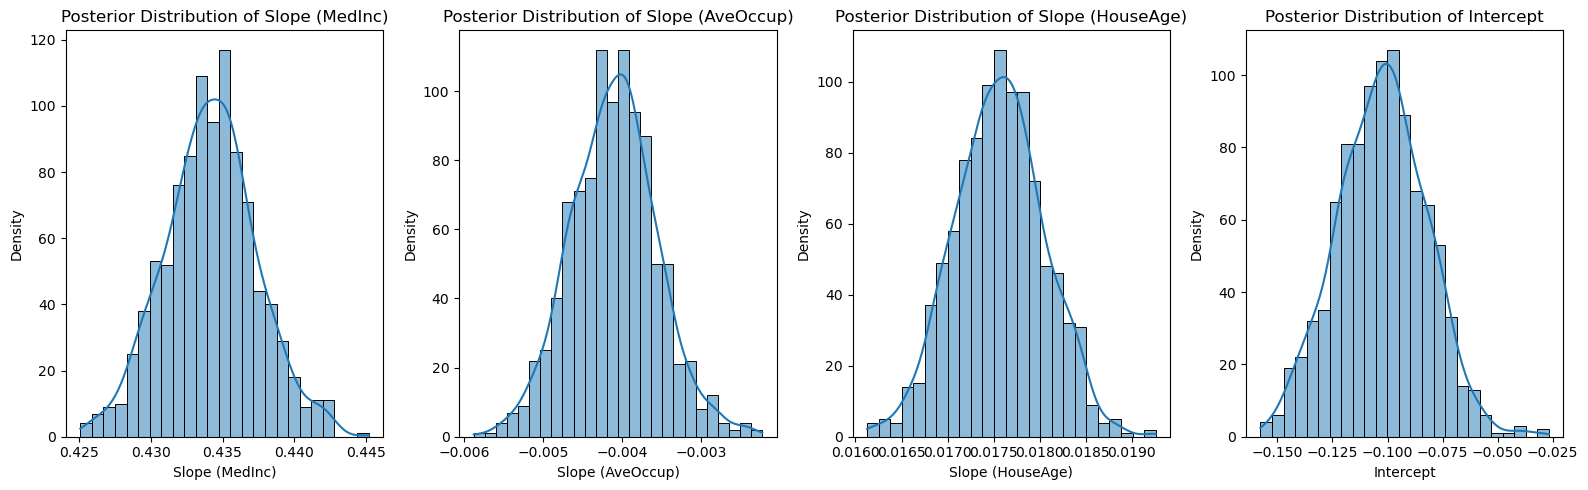

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


posterior_slope = posterior_samples['slope']
posterior_intercept = posterior_samples['intercept']


num_features = posterior_slope.shape[1]

fig, axes = plt.subplots(1, num_features + 1, figsize=(16, 5))


for i in range(num_features):
    sns.histplot(posterior_slope[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'Posterior Distribution of Slope ({features[i]})')
    axes[i].set_xlabel(f'Slope ({features[i]})')
    axes[i].set_ylabel('Density')

sns.histplot(posterior_intercept, kde=True, ax=axes[num_features])
axes[num_features].set_title('Posterior Distribution of Intercept')
axes[num_features].set_xlabel('Intercept')
axes[num_features].set_ylabel('Density')

plt.tight_layout()
plt.show()

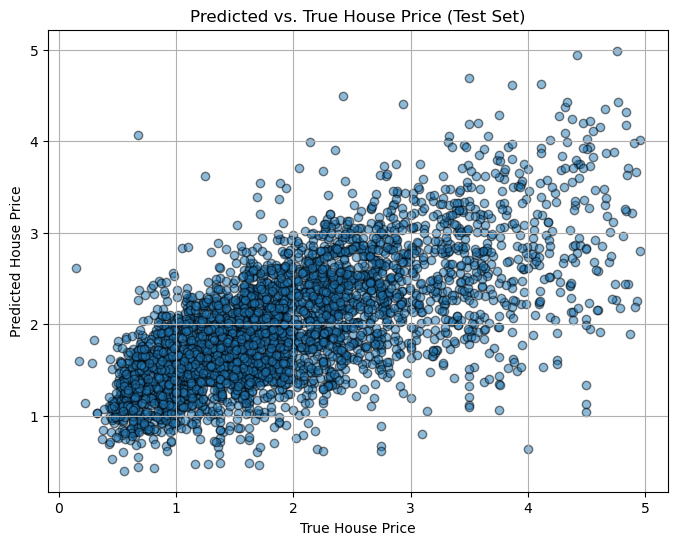

In [15]:
import matplotlib.pyplot as plt


predicted_values = torch.matmul(X_test, mean_slope) + mean_intercept


actual_prices = y_test.numpy()
predicted_prices = predicted_values.numpy()


filter_condition = (actual_prices < 5) & (predicted_prices < 5)
filtered_actual_prices = actual_prices[filter_condition]
filtered_predicted_prices = predicted_prices[filter_condition]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_actual_prices, filtered_predicted_prices, alpha=0.5, edgecolors='black')
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Predicted vs. True House Price (Test Set)')
plt.grid(True)

plt.show()
